In [1]:
import numpy as np
from num2words import num2words
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, TimeDistributed, Dense, SimpleRNN, RepeatVector, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from termcolor import colored

In [3]:
# Adding space and letters for text-based arithmetic or what is called creating a vocabulary
all_chars = '0123456789abcdefghijklmnopqrstuvwxyz +-'

num_features = len(all_chars)
print('Number of features:', num_features)

# Character to index and index to character mappings
char_to_index = {c: i for i, c in enumerate(all_chars)}
index_to_char = {i: c for i, c in enumerate(all_chars)}

Number of features: 39


In [5]:
from num2words import num2words  # Importing num2words for text-based arithmetic

def generate_data():
    first = np.random.randint(0, 100)
    second = np.random.randint(0, 100)

    # Numeric arithmetic
    numeric_example = str(first) + '+' + str(second)
    
    # Text-based arithmetic
    text_example = num2words(first) + ' plus ' + num2words(second)
    
    # Both types share the same label (the result of the addition)
    label = str(first + second)
    
    return numeric_example, text_example, label

# Test generate_data
numeric_example, text_example, label = generate_data()
print("Numeric Example:", numeric_example)
print("Text-based Example:", text_example)
print("Label:", label)

Numeric Example: 16+87
Text-based Example: sixteen plus eighty-seven
Label: 103


In [7]:
def vectorize_example(example, label):
    x = np.zeros((max_time_steps, num_features))
    y = np.zeros((max_time_steps, num_features))

    # Vectorizing the example
    diff_x = max_time_steps - len(example)
    for i, c in enumerate(example):
        x[i + diff_x, char_to_index[c]] = 1
    for i in range(diff_x):
        x[i, char_to_index['0']] = 1  # Padding with '0'

    # Vectorizing the label
    diff_y = max_time_steps - len(label)
    for i, c in enumerate(label):
        y[i + diff_y, char_to_index[c]] = 1
    for i in range(diff_y):
        y[i, char_to_index['0']] = 1  # Padding with '0'

    return x, y

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Dense, SimpleRNN, RepeatVector

hidden_units = 128  # Number of hidden units in the SimpleRNN
max_time_steps = 12  # Set to handle both numeric and text-based inputs

# Updated model definition with Input layer
model = Sequential([
    Input(shape=(None, num_features)),  # Explicit Input layer for specifying the input shape
    SimpleRNN(hidden_units),  # First SimpleRNN layer
    RepeatVector(max_time_steps),  # Repeat vector to match the output size
    SimpleRNN(hidden_units, return_sequences=True),  # Second SimpleRNN layer with return_sequences
    TimeDistributed(Dense(num_features, activation='softmax'))  # TimeDistributed layer for output
])

# Compile the model
model.compile(
   loss='categorical_crossentropy',  # Loss function for categorical data
   optimizer='adam',  # Optimizer
   metrics=['accuracy']  # Metrics to track during training
)

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 12, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 39)         │         5,031 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,431 (232.15 KB)

 Trainable params: 59,431 (232.15 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def vectorize_example(numeric_example, text_example, label):
    x_numeric = np.zeros((max_time_steps, num_features))
    x_text = np.zeros((max_time_steps, num_features))
    y = np.zeros((max_time_steps, num_features))

    # Vectorize the numeric example
    for i, c in enumerate(numeric_example):
        if i < max_time_steps:
            x_numeric[i, char_to_index[c]] = 1
    for i in range(len(numeric_example), max_time_steps):
        x_numeric[i, char_to_index['0']] = 1  # Pad with zeros

    # Vectorize the text example
    for i, c in enumerate(text_example):
        if i < max_time_steps:
            x_text[i, char_to_index[c]] = 1
    for i in range(len(text_example), max_time_steps):
        x_text[i, char_to_index['0']] = 1  # Pad with zeros

    # Vectorize the label
    for i, c in enumerate(label):
        if i < max_time_steps:
            y[i, char_to_index[c]] = 1
    for i in range(len(label), max_time_steps):
        y[i, char_to_index['0']] = 1  # Pad with zeros

    return x_numeric, x_text, y  # Return both input vectors and output vector

def devectorize_example(example):
    result = [index_to_char[np.argmax(vec)] for vec in example]
    return ''.join(result)

# Example usage
numeric_example, text_example, label = generate_data()
print("Numeric Example:", numeric_example)
print("Text-based Example:", text_example)
print("Label:", label)

# Vectorize the examples
x_numeric, x_text, y = vectorize_example(numeric_example, text_example, label)

# Print shapes to verify
print("Numeric Example Shape:", x_numeric.shape)
print("Text-based Example Shape:", x_text.shape)
print("Label Shape:", y.shape)

# Test devectorization (optional)
dev_numeric = devectorize_example(x_numeric)
dev_text = devectorize_example(x_text)
dev_label = devectorize_example(y)

print("Devectorized Numeric Example:", dev_numeric)
print("Devectorized Text-based Example:", dev_text)
print("Devectorized Label:", dev_label)

Numeric Example: 64+86
Text-based Example: sixty-four plus eighty-six
Label: 150
Numeric Example Shape: (12, 39)
Text-based Example Shape: (12, 39)
Label Shape: (12, 39)
Devectorized Numeric Example: 64+860000000
Devectorized Text-based Example: sixty-four p
Devectorized Label: 150000000000


In [13]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_improved_model():
    numeric_input = Input(shape=(max_time_steps, num_features))
    text_input = Input(shape=(max_time_steps, num_features))

    # First LSTM layer for numeric input with increased units and L2 regularization
    numeric_branch = LSTM(512, return_sequences=True, kernel_regularizer='l2')(numeric_input)
    numeric_branch = Dropout(0.3)(numeric_branch)

    # First LSTM layer for text input with increased units and L2 regularization
    text_branch = LSTM(512, return_sequences=True, kernel_regularizer='l2')(text_input)
    text_branch = Dropout(0.3)(text_branch)

    # Concatenate both branches
    combined = Concatenate()([numeric_branch, text_branch])

    # Add more LSTM layers after concatenation with increased units and L2 regularization
    combined = LSTM(512, return_sequences=True, kernel_regularizer='l2')(combined)
    combined = Dropout(0.3)(combined)
    combined = TimeDistributed(Dense(num_features, activation='softmax'))(combined)

    # Compile the model with learning rate decay
    model = Model(inputs=[numeric_input, text_input], outputs=combined)
    model.compile(optimizer=Adam(learning_rate=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [15]:
# Generate training data
num_samples = 5000  # Specify the number of training samples
x_numeric_train, x_text_train, y_train = [], [], []

for _ in range(num_samples):
    numeric_example, text_example, label = generate_data()
    x_numeric, x_text, y = vectorize_example(numeric_example, text_example, label)
    x_numeric_train.append(x_numeric)
    x_text_train.append(x_text)
    y_train.append(y)

# Convert lists to numpy arrays
x_numeric_train = np.array(x_numeric_train)
x_text_train = np.array(x_text_train)
y_train = np.array(y_train)

# Build the improved model
model = build_improved_model()

# Define callbacks
es_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
l_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch}: Validation Accuracy = {logs['val_accuracy']:.2f}"))

# Train the model with more epochs
history = model.fit(
    [x_numeric_train, x_text_train], 
    y_train, 
    epochs=100,  
    batch_size=64, 
    validation_split=0.2, 
    callbacks=[es_cb, l_cb]
)

# Print final accuracy
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"\nFinal Validation Accuracy: {final_val_accuracy * 100:.2f}%")


Epoch 1/200


C:\Users\Shuvam\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6957 - loss: 16.8181Epoch 0: Validation Accuracy = 0.81
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 277ms/step - accuracy: 0.6970 - loss: 16.7860 - val_accuracy: 0.8085 - val_loss: 11.1694
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8098 - loss: 10.1324Epoch 1: Validation Accuracy = 0.81
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8098 - loss: 10.1178 - val_accuracy: 0.8085 - val_loss: 7.4161
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8086 - loss: 6.7400Epoch 2: Validation Accuracy = 0.81
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.8086 - loss: 6.7305 - val_accuracy: 0.8085 - val_loss: 4.9588
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8100 - loss: 4.5127Epoch 3: Validation Accuracy = 0.81
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.8100 - loss: 4.5065 - val_accuracy: 0.8085 - val_loss: 3.3476
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms

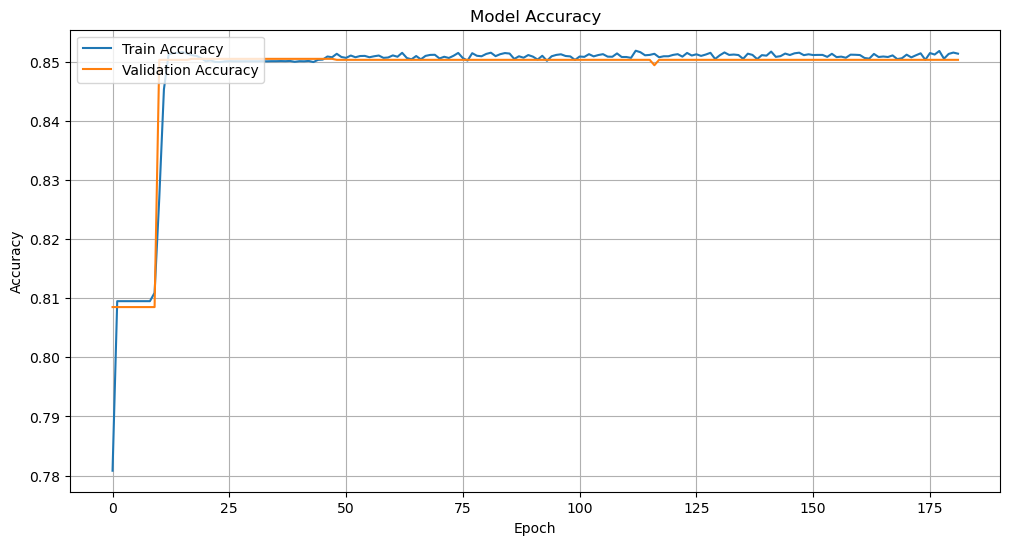

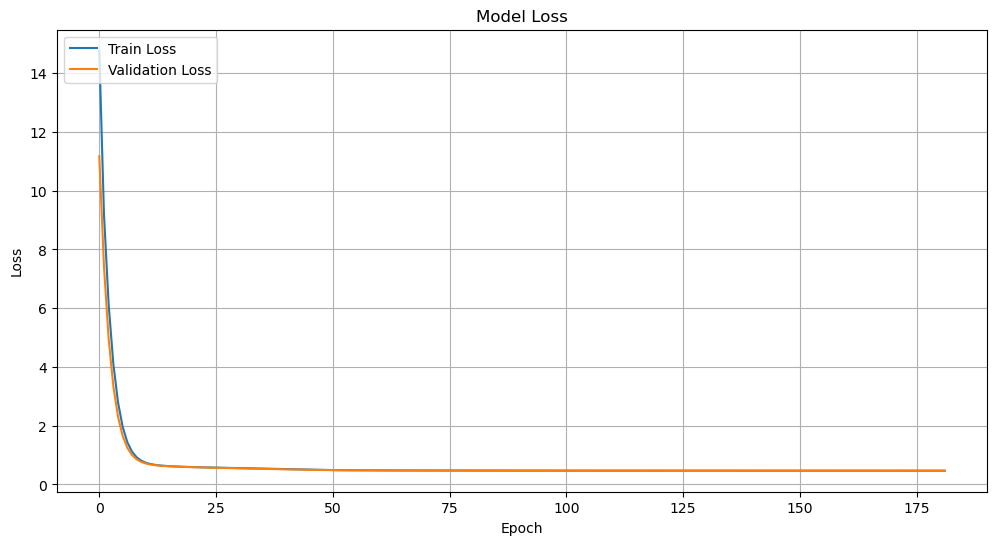

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Numeric Input: 69+980000000
Text Input: sixty-nine p
True Output: 167000000000
Predicted Output: 100000000000
--------------------------------------------------
Numeric Input: 70+970000000
Text Input: seventy plus
True Output: 167000000000
Predicted Output: 100000000000
--------------------------------------------------
Numeric Input: 68+200000000
Text Input: sixty-eight 
True Output: 880000000000
Predicted Output: 100000000000
--------------------------------------------------
Numeric Input: 25+170000000
Text Input: twenty-five 
True Output: 420000000000
Predicted Output: 100000000000
--------------------------------------------------
Numeric Input: 51+440000000
Text Input: fifty-one pl
True Output: 950000000000
Predicted Output: 100000000000
--------------------------------------------------


In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Function to visualize predictions
def plot_predictions(numeric_input, text_input, true_output, pred_output, n=5):
    for i in range(n):
        print(f"Numeric Input: {devectorize_example(numeric_input[i])}")
        print(f"Text Input: {devectorize_example(text_input[i])}")
        print(f"True Output: {devectorize_example(true_output[i])}")
        print(f"Predicted Output: {devectorize_example(pred_output[i])}")
        print('-' * 50)

# Example usage: visualize first 5 predictions
pred_output = model.predict([x_numeric_train[:5], x_text_train[:5]])
plot_predictions(x_numeric_train[:5], x_text_train[:5], y_train[:5], pred_output)
